# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # baseline module

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
from ConsumerProblem import HouseholdSpecializationModelClass


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

**Explain how you solve the model**

Insert explanation:


In [16]:
alpha_list = [0.25, 0.50, 0.75]
sigma_list = [0.5, 1.0, 1.5]

Household = HouseholdSpecializationModelClass()
alpha_list2 = []
sigma_list2 = []
HF_list = []
HM_list = []
HF_HM_list = []
#c. main
for i_alpha,alpha in enumerate(alpha_list):
    for i_sigma,sigma in enumerate(sigma_list):
            Household.par.alpha = alpha
            Household.par.sigma = sigma
            result = Household.solve_discrete()
        
            #res_list.append(result.HF/result.HM)
            alpha_list2.append(alpha)
            sigma_list2.append(sigma)
            HF_list.append(result.HF)
            HM_list.append(result.HM)
            HF_HM_list.append(result.HF/result.HM)
#Generer dataframe df

df= pd.DataFrame().from_dict({'alpha':alpha_list2,'sigma':sigma_list2,'HF':HF_list,'HM':HM_list,'HF/HM':HF_HM_list})
df['HF/HM'] = df['HF/HM'].apply(lambda x: f'{x:2.2f}') 
df

c:\Users\krist\OneDrive - Københavns Universitet\8. semester\Introduction to programming and numerical analysis\projects-2023-magnus-kristian\inauguralproject\ConsumerProblem.py:59: RuntimeWarning: divide by zero encountered in reciprocal
  H=((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))


,alpha,sigma,HF,HM,HF/HM
0,0.25,0.5,3.0,5.5,0.55
1,0.25,1.0,2.0,6.5,0.31
2,0.25,1.5,1.5,7.0,0.21
3,0.50,0.5,4.5,4.5,1.00
4,0.50,1.0,4.5,4.5,1.00
5,0.50,1.5,4.5,4.5,1.00
6,0.75,0.5,5.5,3.0,1.83
7,0.75,1.0,6.5,2.0,3.25
8,0.75,1.5,7.0,1.5,4.67


# Question 2

Explain your code and procedure

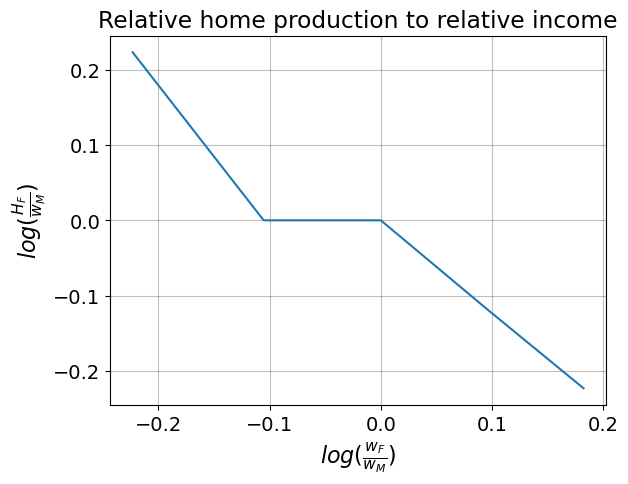

In [42]:
log_HF_HM_list = []
log_wF_wM_list = []
Household = HouseholdSpecializationModelClass()
#c. main
for wF in Household.par.wF_vec:
            Household.par.wF = wF
            result = Household.solve_discrete()
            log_HF_HM_list.append(np.log(result.HF/result.HM))
            log_wF_wM_list.append(np.log(Household.par.wF/Household.par.wM))

# a. create the figure
fig = plt.figure()

# b. plot
ax = fig.add_subplot(1,1,1)

ax.plot(log_wF_wM_list,log_HF_HM_list)

ax.set_title('Relative home production to relative income')
ax.set_xlabel(r'$log(\frac{w_F}{w_M})$', fontsize=16)
ax.set_ylabel(r'$log(\frac{H_F}{w_M})$', fontsize=16);

In [ ]:
# a. create the figure
fig = plt.figure()

# b. 
ax = fig.add_subplot(1,1,1)



n = 10
for x2 in range(1,n):
    u_vec_x2 = u_func(x1_vec,x2)
    ax.plot(x1_vec,u_vec_x2,label='$x_{2}=$'+str(x2),c=(0.,0.1,x2/n)) # c is the color, the argument is the color in rgb format (in percentages of 255)

ax.set_title('Value of choice, $u(x_1,x_2)$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$u(x_1,x_2)$')
ax.legend(loc='upper left',prop={'size':9}); # Activate legend (uses the labels in ax.plot())


# Question 3

Explain your code and procedure

In [ ]:
# code

ADD CONCISE CONLUSION.